In [1]:
import time
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tempfile import TemporaryDirectory

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

In [3]:
data_dir = "./datasets/hymenoptera_data"
# transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
# load images from folder
image_datasets = {x: datasets.ImageFolder(osp.join(data_dir, x), data_transforms[x])
                  for x in ['train','val']}
# data loader
dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [4]:
def imshow(inp, title=None):
  # display image for tensor
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

In [5]:
# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

In [6]:
# make a grid from batch
outs = torchvision.utils.make_grid(inputs)

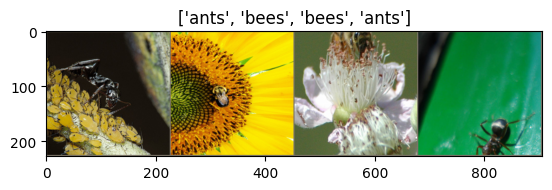

In [7]:
imshow(outs, title=[class_names[x] for x in classes])

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  # Create a temporary directory to save training checkpoints
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        # scheduling the learning rate
        if phase == 'train':
          scheduler.step()

        # average loss
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_params_path)

      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
  return model

In [10]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6397 Acc: 0.6598
val Loss: 0.2195 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5283 Acc: 0.7418
val Loss: 0.8624 Acc: 0.7059

Epoch 2/24
----------
train Loss: 0.4826 Acc: 0.8115
val Loss: 0.3560 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.4996 Acc: 0.7828
val Loss: 0.3183 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5500 Acc: 0.7705
val Loss: 0.2651 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5868 Acc: 0.7500
val Loss: 0.3179 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.3609 Acc: 0.8279
val Loss: 0.2102 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3619 Acc: 0.8484
val Loss: 0.1841 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2578 Acc: 0.8566
val Loss: 0.1934 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2754 Acc: 0.8934
val Loss: 0.1855 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2977 Acc: 0.8689
val Loss: 0.1895 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3381 Acc: 0.8402
val Loss: 0.2047 Acc: 0.9346

Ep

In [12]:
def visualize_model_predictions(model,img_path):
  was_training = model.training
  model.eval()

  img = Image.open(img_path)
  img = data_transforms['val'](img)
  img = img.unsqueeze(0)
  img = img.to(device)

  with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs, 1)

    ax = plt.subplot(2,2,1)
    ax.axis('off')
    ax.set_title(f'Predicted: {class_names[preds[0]]}')
    imshow(img.cpu().data[0])

    model.train(mode=was_training)

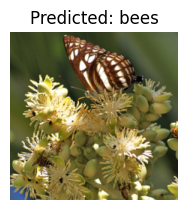

In [13]:
visualize_model_predictions(
    model_ft,
    img_path='./datasets/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)
plt.ioff()
plt.show()